# Analysis of Summary Field Metadata

In [37]:
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from tabulate import tabulate

In [2]:
data = pd.read_json("../data/dump.json")

There are over 7,900 messages in the data dump.

In [3]:
data.shape

(7949, 19)

In [4]:
data.head()

,action,change_size,flags,geo_ip,hashtags,is_anon,is_bot,is_minor,is_new,is_unpatrolled,mentions,ns,page_title,parent_rev_id,rev_id,summary,timestamp,url,user
0,edit,377.0,None,NaN,[],False,False,False,False,False,[],Talk,Talk:Bajadasaurus,883357329.0,883356516.0,/* Images */,2019-02-14 22:43:57.810307,https://en.wikipedia.org/w/index.php?diff=8833...,FunkMonk
1,edit,-66.0,None,NaN,[],False,False,False,False,False,[],Main,The King of Fighters: Maximum Impact,883357327.0,883220913.0,None,2019-02-14 22:43:58.168588,https://en.wikipedia.org/w/index.php?diff=8833...,Benjaminkirsc
2,edit,-4635.0,B,NaN,[],False,True,False,False,False,[],User,User:AlexNewArtBot/WomensHistorySearchResult,883357322.0,883032645.0,"most recent results, added 113, removed 145, t...",2019-02-14 22:43:58.324169,https://en.wikipedia.org/w/index.php?diff=8833...,InceptionBot
3,edit,1.0,None,NaN,[],False,False,False,False,False,[],Template,Template:Samoa-party-stub,883357331.0,398617982.0,None,2019-02-14 22:43:58.613009,https://en.wikipedia.org/w/index.php?diff=8833...,HapHaxion
4,edit,37.0,None,NaN,[],False,False,False,False,False,[],Main,Persela Lamongan,883357330.0,883030131.0,None,2019-02-14 22:43:58.668958,https://en.wikipedia.org/w/index.php?diff=8833...,Afria Nuswantara


In [5]:
data.tail()

,action,change_size,flags,geo_ip,hashtags,is_anon,is_bot,is_minor,is_new,is_unpatrolled,mentions,ns,page_title,parent_rev_id,rev_id,summary,timestamp,url,user
7944,edit,-6.0,None,NaN,[],False,False,False,False,False,[],Template,Template:New Jersey State Senators,883364554.0,880713885.0,None,2019-02-14 23:43:53.182064,https://en.wikipedia.org/w/index.php?diff=8833...,Muboshgu
7945,edit,77.0,M,NaN,[],False,False,True,False,False,[],Main,Paulo Gazzaniga,883364555.0,882837596.0,None,2019-02-14 23:43:55.498175,https://en.wikipedia.org/w/index.php?diff=8833...,Car rush 1
7946,edit,30.0,N,NaN,[],False,False,False,True,False,[],Main,Inun-onan,NaN,883364557.0,[[WP:AES|←]]Redirected page to [[Paksiw#Inun-u...,2019-02-14 23:43:55.966439,https://en.wikipedia.org/w/index.php?oldid=883...,Obsidian Soul
7947,edit,-1.0,None,"{'city': 'Miami', 'country_name': 'United Stat...",[],True,False,False,False,False,[],Main,W. A. Martin,883364556.0,803817668.0,None,2019-02-14 23:43:56.318894,https://en.wikipedia.org/w/index.php?diff=8833...,2601:586:4104:6907:1E1:4F96:64E6:D917
7948,edit,7.0,MB,NaN,[],False,True,True,False,False,[],Main,Bruce Mayrock,883364558.0,878429616.0,Bot: Fixing double redirect to [[Nigerian Civi...,2019-02-14 23:43:57.136671,https://en.wikipedia.org/w/index.php?diff=8833...,EmausBot


The dataset was collected over an hour long period from approximately 22:43-23:43 14th February 2019.

In [6]:
print("Starting timestamp", data.timestamp.min())
print("Ending timestamp", data.timestamp.max())

Starting timestamp 2019-02-14 22:43:57.810307
Ending timestamp 2019-02-14 23:43:57.136671


The dataset contains messages relating to the English language site only, as far as can be determined.

In [44]:
data[data.url.str.contains("en.wikipedia.org") == True].shape

(7008, 19)

In [45]:
data[data.url.str.contains("en.wikipedia.org").isnull()].shape

(941, 19)

In [108]:
data[data.is_bot == False].shape

(6937, 19)

In [161]:
data[(data.is_anon == True) & (data.action == "edit")].ns.value_counts()

Main         1007
Talk           18
Template        7
Project         6
User talk       5
Draft           5
Category        2
Portal          1
Help            1
User            1
Name: ns, dtype: int64

In [82]:
# only consider edits to main articles submitted by people rather than bots
main_articles = data[(data.ns == "Main") & (data.is_bot == False)]
main_articles.is_anon.value_counts()

False    3462
True     1007
Name: is_anon, dtype: int64

In [46]:
main_articles.summary.isnull().value_counts()

False    3577
True      892
Name: summary, dtype: int64

In [198]:
anonymous_users = main_articles[main_articles.is_anon == True]
registered_users = main_articles[main_articles.is_anon == False]

anonymous_users_no_summary = anonymous_users[anonymous_users.summary.isnull()].shape[0]
registered_users_no_summary = registered_users[registered_users.summary.isnull()].shape[0]

In [186]:
registered_users_no_summary

518

In [109]:
print(anonymous_users_no_summary / anonymous_users.shape[0])
print(registered_users_no_summary / registered_users.shape[0])

0.3714001986097319
0.14962449451184287


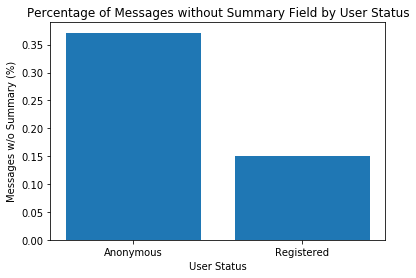

In [60]:
fig, ax = plt.subplots()
plt.bar(["Anonymous", "Registered"], [anonymous_users_no_summary / anonymous_users.shape[0], registered_users_no_summary / registered_users.shape[0]])
plt.xlabel('User Status')
plt.ylabel('Messages w/o Summary (%)')
plt.title('Percentage of Messages without Summary Field by User Status')
plt.show()

In [169]:
anonymous_users[anonymous_users.summary.isnull()].shape[0]
anonymous_users[~anonymous_users.summary.isnull()].shape[0]

633

In [206]:
anonymous_users.shape

(1007, 19)

In [207]:
registered_users.shape

(3462, 19)

In [199]:
registered_users[registered_users.summary.isnull()].shape[0]

518

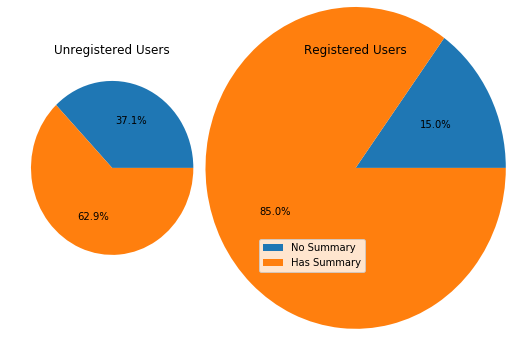

In [267]:
labels = "No Summary", "Has Summary"
unregistered_users_data = [anonymous_users[anonymous_users.summary.isnull()].shape[0], anonymous_users[~anonymous_users.summary.isnull()].shape[0]]
registered_users_data = [registered_users[registered_users.summary.isnull()].shape[0], registered_users[~registered_users.summary.isnull()].shape[0]]

fig, ax = plt.subplots(1, 2)
fig.set_size_inches((8, 4))


ax[0].pie(unregistered_users_data, autopct='%1.1f%%')
ax[0].set_title("Unregistered Users")
ax[1].pie(registered_users_data, autopct='%1.1f%%', radius=1.85)
ax[1].set_title("Registered Users")

plt.legend(labels, loc="best")
plt.show()

In [167]:
anonymous_users = np.array(anonymous_users[anonymous_users.summary.isnull()].shape[0],anonymous_users[~anonymous_users.summary.isnull()].shape[0])

data2 = np.array([0.6, 0.4])

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# plot each pie chart in a separate subplot
ax1.pie(anonymous_users)
ax2.pie(data2)

TypeError: data type not understood

In [69]:
anonymous_users_with_summary = anonymous_users[~anonymous_users.summary.isnull()]
registered_users_with_summary = registered_users[~registered_users.summary.isnull()]

In [70]:
def parse_and_tokenize(summary):
    
    # parse summary
    summary = re.sub("[\(\[\/\{].*?[\}\/\)\]]", "", summary).strip()
    summary = " ".join(re.findall("[a-zA-Z]+", summary))
    summary = summary.lower()

    # get verbs only
    is_verb = lambda pos: pos[:2] == "VB"
    tokenized = nltk.word_tokenize(summary)
    verbs = [word for (word, pos) in nltk.pos_tag(tokenized) if is_verb(pos)]
    
    return verbs
    

In [71]:
anonymous_users_with_summary["verbs"] = anonymous_users_with_summary.summary.apply(parse_and_tokenize)
registered_users_with_summary["verbs"] = registered_users_with_summary.summary.apply(parse_and_tokenize)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
class Lemmatizer(object):
    
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def __call__(self, verbs):
        return [self.lemmatizer.lemmatize(verb, "v") for verb in verbs]

In [134]:
def get_verbs_idf(verbs):

    clf = TfidfVectorizer(tokenizer=Lemmatizer(), lowercase=False, stop_words=set(stopwords.words('english')))
    clf.fit(verbs)

    word2idf = dict(zip(clf.get_feature_names(), clf.idf_))
    return sorted(word2idf.items(), key=lambda x: x[1], reverse=False)

In [135]:
anonymous_users_sorted_idf = get_verbs_idf(anonymous_users_with_summary[anonymous_users_with_summary.verbs.str.len() != 0].verbs)
registered_users_sorted_idf = get_verbs_idf(registered_users_with_summary[registered_users_with_summary.verbs.str.len() != 0].verbs)

In [136]:
len(anonymous_users_sorted_idf)

94

In [152]:
anonymous_users_sorted_idf[:10]

[('add', 2.3523928094442095),
 ('fix', 2.6933193964148026),
 ('remove', 3.163323025660538),
 ('correct', 3.6741486494265287),
 ('change', 3.9618307218783095),
 ('update', 3.9618307218783095),
 ('improve', 4.772760938094638),
 ('make', 4.772760938094638),
 ('miss', 4.772760938094638),
 ('edit', 5.060443010546419)]

In [138]:
len(registered_users_sorted_idf)

359

In [153]:
registered_users_sorted_idf[:10]

[('add', 1.7867984561364523),
 ('revert', 3.1198379137207994),
 ('use', 3.152273189473953),
 ('fix', 3.9868320240837267),
 ('remove', 4.136772171374641),
 ('clean', 4.313228608716198),
 ('change', 4.922292672065602),
 ('create', 4.955082494888593),
 ('repair', 5.2207856606215985),
 ('surname', 5.2207856606215985)]

In [140]:
def get_word_synonyms(word, sent):
    word_synonyms = []
    for synset in wordnet.synsets(word):
        for lemma in synset.lemma_names():
            if lemma in sent and lemma != word:
                word_synonyms.append(lemma)
    
    if len(word_synonyms) == 0:
        return "No synonyms found"
    else:
        return ", ".join(word_synonyms)

In [156]:
anonymous_users_verbs

['add',
 'fix',
 'remove',
 'correct',
 'change',
 'update',
 'improve',
 'make',
 'miss',
 'edit',
 'f',
 'fit',
 'refer',
 'reflect',
 'replace',
 'say',
 'shoot',
 'specify',
 'take',
 'turn',
 'accompany',
 'accord',
 'account',
 'acquire',
 'adjust',
 'allah',
 'amend',
 'anyways',
 'bear',
 'bore',
 'build',
 'byh',
 'call',
 'capitalize',
 'career',
 'cite',
 'close',
 'complete',
 'condemn',
 'contest',
 'crew',
 'cultivate',
 'disestablish',
 'dispute',
 'doesnt',
 'eliminate',
 'external',
 'feminine',
 'ferry',
 'forget',
 'form',
 'found',
 'frank',
 'fred',
 'go',
 'gus',
 'january',
 'john',
 'link',
 'live',
 'masculine',
 'mcdonald',
 'medved',
 'mil',
 'ongoing',
 'open',
 'pixel',
 'please',
 'ppricem',
 'prove',
 'provide',
 'put',
 'reopen',
 'repeat',
 'rephrase',
 'represent',
 'require',
 'reverse',
 'see',
 'seem',
 'select',
 'separate',
 'serve',
 'show',
 'sympathetic',
 'talk',
 'transfer',
 'trim',
 'use',
 'wait',
 'word',
 'work',
 'worry',
 'write']

In [155]:
registered_users_verbs

['add',
 'revert',
 'use',
 'fix',
 'remove',
 'clean',
 'change',
 'create',
 'repair',
 'surname',
 'fill',
 'update',
 'need',
 'correct',
 'move',
 'make',
 'miss',
 'see',
 'link',
 'redirect',
 'e',
 'edit',
 'import',
 'shortdesc',
 'say',
 'expand',
 'format',
 'c',
 'clarify',
 'ref',
 'restore',
 'write',
 'base',
 'describe',
 'identify',
 'include',
 'spell',
 'find',
 'get',
 'go',
 'know',
 'mention',
 'reference',
 'replace',
 'f',
 'improve',
 'infobox',
 'pending',
 'read',
 'seem',
 'source',
 'space',
 'tag',
 'think',
 'word',
 'begin',
 'break',
 'delete',
 'ex',
 'exist',
 'finish',
 'indicate',
 'let',
 'list',
 'look',
 'merge',
 'name',
 'open',
 'refs',
 'rescue',
 'rouploads',
 'sort',
 'sound',
 'start',
 'suggest',
 'support',
 'unsourced',
 'accept',
 'adjust',
 'alphabetize',
 'announce',
 'appear',
 'b',
 'band',
 'become',
 'blank',
 'cite',
 'close',
 'consider',
 'continue',
 'discuss',
 'dispute',
 'edge',
 'end',
 'endash',
 'explain',
 'express',
 

In [141]:
anonymous_users_verbs, anonymous_users_idfs = zip(*anonymous_users_sorted_idf)
anonymous_users_verbs = list(anonymous_users_verbs)
anonymous_users_idfs = list(anonymous_users_idfs)

for verb in anonymous_users_verbs[:5]:
    print(verb)
    print(get_word_synonyms(verb, anonymous_users_verbs))
    print("-------------------------")

add
No synonyms found
-------------------------
fix
specify, make
-------------------------
remove
take, transfer
-------------------------
correct
adjust
-------------------------
change
transfer
-------------------------


In [142]:
registered_users_verbs, registered_users_idfs = zip(*registered_users_sorted_idf)
registered_users_verbs = list(registered_users_verbs)
registered_users_idfs = list(registered_users_idfs)

for verb in registered_users_verbs[:5]:
    print(verb)
    print(get_word_synonyms(verb, registered_users_verbs))
    print("-------------------------")

add
No synonyms found
-------------------------
revert
return
-------------------------
use
No synonyms found
-------------------------
fix
jam, repair, repair, restore, specify, define, make, get
-------------------------
remove
take
-------------------------


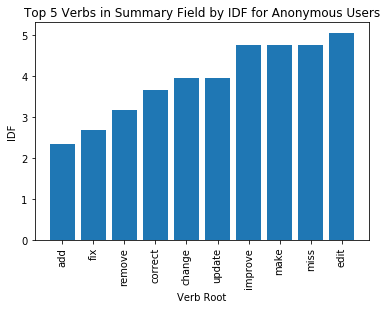

In [164]:
fig, ax = plt.subplots()

plt.bar(anonymous_users_verbs[:10], anonymous_users_idfs[:10])
plt.xticks(rotation='vertical')
plt.xlabel('Verb Root')
plt.ylabel('IDF')
plt.title('Top 5 Verbs in Summary Field by IDF for Anonymous Users')
plt.show()

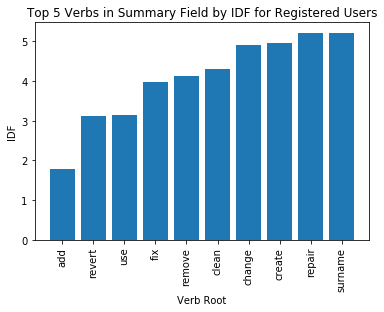

In [163]:
fig, ax = plt.subplots()

plt.bar(registered_users_verbs[:10], registered_users_idfs[:10])
plt.xticks(rotation='vertical')
plt.xlabel('Verb Root')
plt.ylabel('IDF')
plt.title('Top 5 Verbs in Summary Field by IDF for Registered Users')
plt.show()

In [158]:
np.setdiff1d(anonymous_users_verbs,registered_users_verbs)

array(['accompany', 'accord', 'account', 'acquire', 'allah', 'amend',
       'anyways', 'bore', 'build', 'byh', 'call', 'capitalize', 'career',
       'condemn', 'crew', 'cultivate', 'disestablish', 'doesnt',
       'external', 'feminine', 'ferry', 'forget', 'form', 'found',
       'frank', 'fred', 'gus', 'january', 'john', 'masculine', 'mcdonald',
       'medved', 'mil', 'ongoing', 'pixel', 'ppricem', 'prove', 'refer',
       'reflect', 'reopen', 'represent', 'require', 'reverse', 'separate',
       'serve', 'shoot', 'sympathetic', 'transfer', 'turn', 'wait',
       'worry'], dtype='<U12')

In [159]:
np.setdiff1d(registered_users_verbs,anonymous_users_verbs)

array(['accept', 'accuse', 'afghanistan', 'ahmed', 'alexander', 'algebra',
       'alphabetize', 'alt', 'alter', 'alternative', 'announce', 'appear',
       'archive', 'article', 'assault', 'assert', 'assist', 'assume',
       'attend', 'attribute', 'avoid', 'b', 'balance', 'band', 'barbados',
       'base', 'become', 'begin', 'biography', 'blank', 'bowl', 'brave',
       'break', 'buy', 'c', 'caplitalized', 'caption', 'cast', 'cb', 'cc',
       'challenge', 'chart', 'check', 'clarify', 'cleae', 'clean', 'club',
       'colette', 'collaborate', 'columnised', 'combine', 'come', 'comey',
       'comhindipakistan', 'commit', 'compute', 'concert', 'confirm',
       'confuse', 'connect', 'consider', 'contain', 'continue',
       'contract', 'convert', 'count', 'create', 'credit', 'cut', 'dash',
       'date', 'decease', 'dedicate', 'define', 'delete', 'deorphaned',
       'describe', 'develop', 'dickens', 'die', 'discuss', 'e', 'ed',
       'edge', 'emfbroadcasting', 'end', 'endash', 'enjoy